<a href="https://colab.research.google.com/github/JamesMcGuigan/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install tf-nightly-2.0-preview


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc1


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time        = np.arange(4 * 365 + 1, dtype="float32")
baseline    = 10
series      = trend(time, 0.1)  
baseline    = 10
amplitude   = 40
slope       = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train    = series[:split_time]
time_valid = time[split_time:]
x_valid    = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [19]:
dataset = windowed_dataset(x_train.copy(), window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

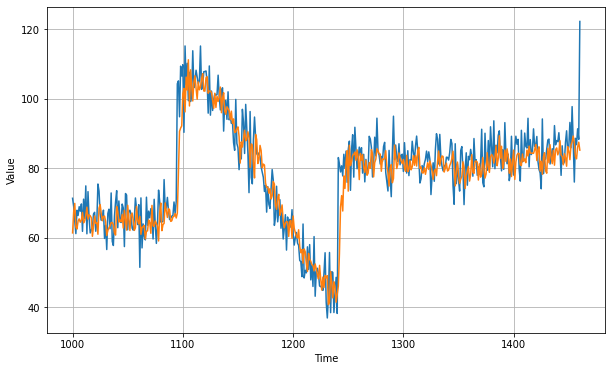

In [20]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [6]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.5406046

(1e-08, 0.001, 0.0, 300.0)

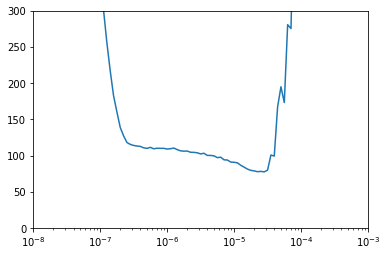

In [7]:
# Without momentum - 4 layers
dataset = windowed_dataset(x_train.copy(), window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(4, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
# plt.semilogx(lrs, history.history["lr"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-08, 0.001, 0.0, 300.0)

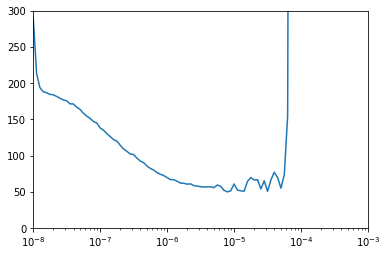

In [18]:
# With momentum - 4 layers
dataset = windowed_dataset(x_train.copy(), window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(4, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-08, 0.001, 0.0, 300.0)

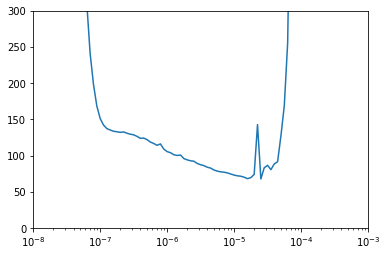

In [9]:
# 10 Units without momentum
dataset = windowed_dataset(x_train.copy(), window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-08, 0.001, 0.0, 300.0)

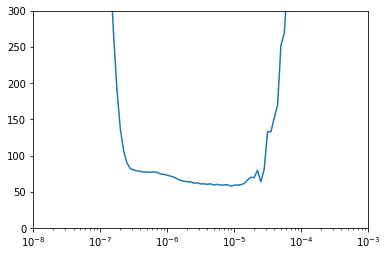

In [10]:
# 5 layers + 10 Units without momentum
dataset = windowed_dataset(x_train.copy(), window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-08, 0.001, 0.0, 300.0)

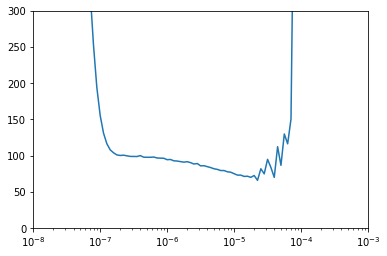

In [11]:
# 16 layers with momentum 
dataset = windowed_dataset(x_train.copy(), window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [72]:
# 16 layers with momentum 
dataset = windowed_dataset(x_train.copy(), window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"), 
    # tf.keras.layers.Dense(8, activation="relu"), 
    # tf.keras.layers.Dense(16, activation="relu"), 
    # tf.keras.layers.Dense(16, activation="relu"), 
    # tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    dataset, 
    epochs=10000, 
    verbose=0, 
    callbacks=[
      tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=50),
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, verbose=1)
    ]
)

Epoch 01130: early stopping


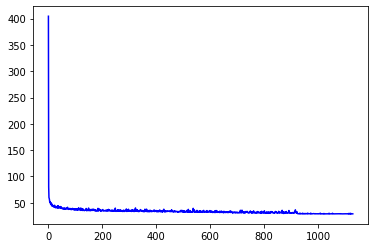

In [73]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[50.100711822509766, 46.600669860839844, 44.18067169189453, 47.623046875, 44.67595672607422, 46.14142990112305, 44.8867073059082, 43.090091705322266, 43.577430725097656, 43.53746795654297, 43.01628112792969, 41.43684768676758, 43.871490478515625, 45.32958221435547, 42.117225646972656, 42.09312438964844, 40.518028259277344, 40.7772216796875, 42.847137451171875, 42.37275695800781, 41.020938873291016, 41.18830108642578, 40.73603439331055, 39.906333923339844, 44.11752700805664, 43.212249755859375, 44.38079071044922, 39.74604797363281, 42.573707580566406, 42.23296356201172, 41.51018524169922, 41.461219787597656, 40.26399230957031, 39.85554122924805, 42.88798141479492, 40.17483139038086, 40.479339599609375, 42.47878646850586, 40.42580795288086, 39.287601470947266, 39.52048873901367, 40.26713180541992, 38.80269241333008, 38.36485290527344, 38.937232971191406, 39.29704666137695, 38.5689697265625, 39.985172271728516, 38.71464538574219, 38.29947280883789, 37.66441345214844, 40.20463943481445, 39

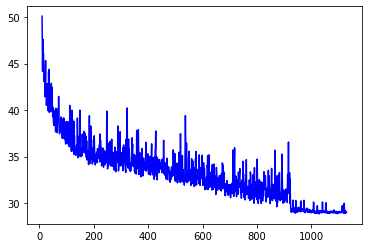

In [74]:
# Plot all but the first 10
loss      = history.history['loss']
epochs    = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

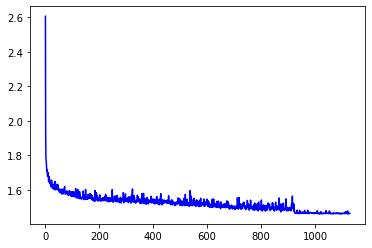

In [75]:
loss   = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, np.log10(loss), 'b', label='Training Log Loss')
plt.show()

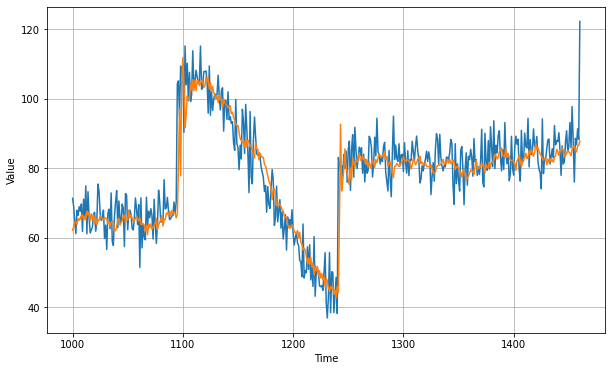

In [76]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results  = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [77]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7938533